# Impacto do Escalonamento Sintético na Performance de Classificadores: Uma Abordagem Baseada em SMOTE

**Escopo do Projeto:** Este notebook realiza o aumento de dados (Data Augmentation) via SMOTE no melhor subespaço de atributos encontrado (40%). O objetivo é observar o comportamento da curva de aprendizado dos algoritmos Random Forest e Decision Tree à medida que o volume de dados aumenta de 20.000 para 100.000 instâncias.

---
## 1. Configurações Iniciais e Bibliotecas

In [21]:
import pandas as pd
import numpy as np
import pickle
import joblib
import os
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.utils import resample



## 2. Acesso aos Dados (Google Drive)
Conectamos ao ambiente do Google Drive para carregar o arquivo Pickle contendo o melhor subespaço de atributos identificado na etapa anterior (40%).

In [16]:
from google.colab import drive

# 1. Conectar ao Google Drive
# Ao rodar esta célula, aparecerá um link ou um pop-up pedindo permissão
drive.mount('/content/drive')

# 2. Definir o caminho do arquivo
# IMPORTANTE: Verifique o nome exato da pasta e do arquivo no seu Drive
# Exemplo: se o arquivo está na raiz do Drive, o caminho começa com /content/drive/MyDrive/
caminho_arquivo = '/content/drive/MyDrive/Data Science - Kaggle/modeling and experimentations/base_40_versao_01.pkl'

# 3. Carregar o arquivo Pickle
try:
    with open(caminho_arquivo, "rb") as f:
        # A ordem deve ser a mesma que você salvou: [X_train, y_train, X_test, y_test]
        X_train, X_test, y_train, y_test = pickle.load(f)

    print("✅ Sucesso: Base de 40% carregada do Google Drive!")
    print(f"Tamanho do treino original: {len(X_train)} instâncias")
    print(f"Tamanho do teste original: {len(X_test)} instâncias")

except FileNotFoundError:
    print("❌ Erro: O arquivo não foi encontrado. Verifique se o caminho no Drive está correto.")
except Exception as e:
    print(f"❌ Ocorreu um erro ao carregar: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Sucesso: Base de 40% carregada do Google Drive!
Tamanho do treino original: 38476 instâncias
Tamanho do teste original: 16490 instâncias


## 3. Análise da Base Original (Treino e Teste)
Antes de gerar as novas variações de tamanho, validamos a integridade dos dados, verificando o balanceamento das 3 classes e a sincronia entre os conjuntos de atributos (X) e rótulos (y).

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38476, 8), (38476,), (16490, 8), (16490,))

In [19]:

# Pegando os valores únicos do seu y_train
nomes_reais = np.unique(y_train)

print("Os identificadores das suas classes são:")
for i, nome in enumerate(nomes_reais):
    print(f"Classe {i+1} (c{i+1}): {nome}")

Os identificadores das suas classes são:
Classe 1 (c1): 0
Classe 2 (c2): 1
Classe 3 (c3): 2


In [20]:
classes, contagens = np.unique(y_train, return_counts=True)

for i in range(len(classes)):
    print(f"Classe: {classes[i]} | Quantidade Original: {contagens[i]}")

Classe: 0 | Quantidade Original: 12874
Classe: 1 | Quantidade Original: 12701
Classe: 2 | Quantidade Original: 12901


## 4. Geração de Base Reduzida: 20.000 Amostras
Como o volume alvo (20k) é menor que o volume original de treino (~38k), utilizamos a técnica de **Amostragem Estratificada** para reduzir o conjunto de treino mantendo o equilíbrio perfeito entre as 3 classes.

In [29]:
# 1. Criar um DataFrame temporário para o sorteio ser preciso
df_temp = pd.DataFrame(X_train)
df_temp['target'] = y_train

# 2. Realizar a amostragem de 20.000 instâncias
# replace=False garante que não haverá linhas repetidas
# stratify garante que as 3 classes continuem equilibradas entre si
df_20k = resample(df_temp,
                  n_samples=20000,
                  replace=False,
                  random_state=0,
                  stratify=df_temp['target'])

# 3. Separar de volta em X e y
X_train_20k = df_20k.drop(columns=['target']).values
y_train_20k = df_20k['target'].values

print(f"✅ Base de 20k criada com sucesso!")
print(f"Novo shape do X_train: {X_train_20k.shape}")
print(f"Novo shape do y_train: {y_train_20k.shape}")

✅ Base de 20k criada com sucesso!
Novo shape do X_train: (20000, 8)
Novo shape do y_train: (20000,)


In [30]:
import collections
print("Distribuição das classes na base de 20k:")
print(collections.Counter(y_train_20k))

Distribuição das classes na base de 20k:
Counter({np.int64(2): 6706, np.int64(0): 6692, np.int64(1): 6602})


## 4.1. Persistência dos Dados (20.000 Amostras)
Nesta etapa, exportamos o conjunto de dados reduzido. O arquivo **Pickle** será utilizado para alimentar os modelos de Machine Learning, preservando a integridade dos arrays, enquanto o arquivo **CSV** permite uma inspeção rápida dos dados gerados.

*Nota: O conjunto de teste permanece o original (16.490 amostras) para garantir que a avaliação seja comparável entre todos os experimentos.*

In [25]:
# --- SALVAR EM PICKLE ---
nome_pkl = "base_40_reduzida_20k.pkl"
with open(nome_pkl, mode="wb") as f:
    # Salvamos o novo treino (20k) e o teste original (16k)
    pickle.dump([X_train_20k, y_train_20k, X_test, y_test], f)

# --- SALVAR EM CSV ---
# Salvaremos apenas o conjunto de treino para conferência
df_20k_csv = pd.DataFrame(X_train_20k)
df_20k_csv['target'] = y_train_20k
df_20k_csv.to_csv("treino_40_reduzida_20k.csv", index=False)

print(f"📦 Arquivos '{nome_pkl}' e 'treino_40_reduzida_20k.csv' salvos com sucesso!")

📦 Arquivos 'base_40_reduzida_20k.pkl' e 'treino_40_reduzida_20k.csv' salvos com sucesso!


## 5. Geração de Base Reduzida: 30.000 Amostras
Assim como na etapa anterior, o volume alvo (30k) ainda é inferior ao tamanho original do treino (~38k). Utilizamos a amostragem estratificada para selecionar 10.000 instâncias de cada uma das 3 classes, garantindo um conjunto perfeitamente balanceado.

In [32]:
df_30k = resample(df_temp,
                  n_samples=30000,
                  replace=False,
                  random_state=0,
                  stratify=df_temp['target'])

X_train_30k =df_30k.drop(columns=["target"]).values
y_train_30k = df_30k["target"].values

print(f"✅ Base de 20k criada com sucesso!")
print(f"Novo shape do X_train: {X_train_30k.shape}")
print(f"Novo shape do y_train: {y_train_30k.shape}")

✅ Base de 20k criada com sucesso!
Novo shape do X_train: (30000, 8)
Novo shape do y_train: (30000,)


In [33]:
print("Distribuição das classes na base de 20k:")
print(collections.Counter(y_train_30k))

Distribuição das classes na base de 20k:
Counter({np.int64(2): 10059, np.int64(0): 10038, np.int64(1): 9903})


## 5.1. Persistência dos Dados (30.000 Amostras)
Nesta etapa, exportamos o conjunto de dados reduzido. O arquivo **Pickle** será utilizado para alimentar os modelos de Machine Learning, preservando a integridade dos arrays, enquanto o arquivo **CSV** permite uma inspeção rápida dos dados gerados.

*Nota: O conjunto de teste permanece o original (16.490 amostras) para garantir que a avaliação seja comparável entre todos os experimentos.*

In [34]:
# --- SALVAR EM PICKLE ---
nome_pkl = "base_40_reduzida_30k.pkl"
with open(nome_pkl, mode="wb") as f:
    # Salvamos o novo treino (30k) e o teste original (16k)
    pickle.dump([X_train_20k, y_train_20k, X_test, y_test], f)

# --- SALVAR EM CSV ---
# Salvaremos apenas o conjunto de treino para conferência
df_20k_csv = pd.DataFrame(X_train_30k)
df_20k_csv['target'] = y_train_30k
df_20k_csv.to_csv("treino_40_reduzida_30k.csv", index=False)

print(f"📦 Arquivos '{nome_pkl}' e 'treino_40_reduzida_30k.csv' salvos com sucesso!")

📦 Arquivos 'base_40_reduzida_30k.pkl' e 'treino_40_reduzida_30k.csv' salvos com sucesso!


## 6. Geração de Base Expandida: 50.000 Amostras (SMOTE)
Nesta fase, ultrapassamos o volume de dados original do conjunto de treinamento. Utilizamos a técnica **SMOTE (Synthetic Minority Over-sampling Technique)** para gerar dados sintéticos.

O objetivo é alcançar um total de 50.000 instâncias, distribuídas de forma equitativa (~16.666 por classe), permitindo que os algoritmos de árvore (Random Forest e Decision Tree) explorem fronteiras de decisão mais densas no subespaço de 40% de atributos.

In [35]:
# 1. Definição da estratégia para 50.000 instâncias totais
# Como temos 3 classes (0, 1 e 2), dividimos o total por 3.
# 50.000 / 3 = 16.666,66... Arredondamos para fechar a conta exata.
estrategia_50k = {0: 16666, 1: 16666, 2: 16668}

# 2. Configuração do SMOTE
# random_state=0 garante que o experimento seja reproduzível
smote_50k = SMOTE(sampling_strategy=estrategia_50k, random_state=0)

# 3. Aplicação do SMOTE no treino original
# O SMOTE cria os novos X e y de forma sincronizada
X_train_50k, y_train_50k = smote_50k.fit_resample(X_train, y_train)

# 4. Verificação da nova distribuição
print(f"✅ Base de 50k gerada com SMOTE!")
print(f"Distribuição final: {collections.Counter(y_train_50k)}")

# 5. Persistência dos Dados
nome_pkl_50k = "base_40_smote_50k.pkl"
with open(nome_pkl_50k, mode="wb") as f:
    # Salvamos o treino de 50k e mantemos o teste original de 16k
    pickle.dump([X_train_50k, y_train_50k, X_test, y_test], f)

# Salvar CSV para inspeção (Treino apenas)
df_50k_csv = pd.DataFrame(X_train_50k)
df_50k_csv['target'] = y_train_50k
df_50k_csv.to_csv("treino_40_smote_50k.csv", index=False)

print(f"📦 Arquivos '{nome_pkl_50k}' e 'treino_40_smote_50k.csv' salvos.")

✅ Base de 50k gerada com SMOTE!
Distribuição final: Counter({np.int64(2): 16668, np.int64(1): 16666, np.int64(0): 16666})
📦 Arquivos 'base_40_smote_50k.pkl' e 'treino_40_smote_50k.csv' salvos.


## 7. Geração de Base Expandida: 40.000 Amostras (Início do SMOTE)
Nesta etapa, atingimos um volume superior ao conjunto de treinamento original (~38k). Utilizamos o **SMOTE** para realizar um leve aumento de dados, gerando instâncias sintéticas suficientes para que cada uma das 3 classes atinja a marca de aproximadamente 13.333 exemplos.

Este experimento é crucial para observar se um pequeno acréscimo de dados sintéticos (cerca de 1.500 novas instâncias no total) já é capaz de estabilizar as fronteiras de decisão do Random Forest.

In [36]:
# 1. Definição da estratégia para 40.000 instâncias totais
# 40.000 / 3 = 13.333,33...
estrategia_40k = {0: 13333, 1: 13333, 2: 13334}

# 2. Configuração do SMOTE
smote_40k = SMOTE(sampling_strategy=estrategia_40k, random_state=0)

# 3. Aplicação do SMOTE no treino original (38.476 -> 40.000)
X_train_40k, y_train_40k = smote_40k.fit_resample(X_train, y_train)

# 4. Verificação
print(f"✅ Base de 40k gerada!")
print(f"Distribuição final: {collections.Counter(y_train_40k)}")

# 5. Persistência dos Dados
nome_pkl_40k = "base_40_smote_40k.pkl"
with open(nome_pkl_40k, mode="wb") as f:
    # Salvamos o treino de 40k e mantemos o teste original de 16k
    pickle.dump([X_train_40k, y_train_40k, X_test, y_test], f)

# Salvar CSV para inspeção
df_40k_csv = pd.DataFrame(X_train_40k)
df_40k_csv['target'] = y_train_40k
df_40k_csv.to_csv("treino_40_smote_40k.csv", index=False)

print(f"📦 Arquivos '{nome_pkl_40k}' e 'treino_40_smote_40k.csv' salvos.")

✅ Base de 40k gerada!
Distribuição final: Counter({np.int64(2): 13334, np.int64(1): 13333, np.int64(0): 13333})
📦 Arquivos 'base_40_smote_40k.pkl' e 'treino_40_smote_40k.csv' salvos.


## 8. Geração de Base de Alta Volumetria: 100.000 Amostras (SMOTE)
Esta é a etapa final da geração de dados. Expandimos o conjunto de treinamento para 100.000 instâncias, utilizando o **SMOTE** para criar uma vasta densidade de exemplos sintéticos.

Com aproximadamente 33.333 amostras por classe, este experimento visa verificar se o aumento drástico do volume de dados compensa a baixa correlação dos atributos originais, permitindo que o modelo Random Forest capture padrões estatísticos que seriam invisíveis em bases menores.

In [39]:
# 1. Definição da estratégia para 40.000 instâncias totais
# 100.000 / 3 = 33.333,33...
estrategia_100k = {0: 33333, 1: 33333, 2: 33334}

# 2. Configuração do SMOTE
smote_100k = SMOTE(sampling_strategy=estrategia_100k, random_state=0)

# 3. Aplicação do SMOTE no treino original (38.476 -> 100.000)
X_train_100k, y_train_100k = smote_100k.fit_resample(X_train, y_train)

# 4. Verificação
print(f"✅ Base de 100k gerada!")
print(f"Distribuição final: {collections.Counter(y_train_100k)}")

# 5. Persistência dos Dados
nome_pkl_100k = "base_40_smote_100k.pkl"
with open(nome_pkl_100k, mode="wb") as f:
    # Salvamos o treino de 100k e mantemos o teste original de 16k
    pickle.dump([X_train_100k, y_train_100k, X_test, y_test], f)

# Salvar CSV para inspeção
df_100k_csv = pd.DataFrame(X_train_100k)
df_100k_csv['target'] = y_train_100k
df_100k_csv.to_csv("treino_40_smote_100k.csv", index=False)

print(f"📦 Arquivos '{nome_pkl_100k}' e 'treino_40_smote_100k.csv' salvos.")

✅ Base de 100k gerada!
Distribuição final: Counter({np.int64(2): 33334, np.int64(1): 33333, np.int64(0): 33333})
📦 Arquivos 'base_40_smote_100k.pkl' e 'treino_40_smote_100k.csv' salvos.


In [40]:
X_train_100k.shape, y_train_100k.shape

((100000, 8), (100000,))

# 9.1. Treinamento: Base 20k (Redução Estratificada)
Este experimento avalia a performance dos modelos utilizando apenas uma fração dos dados originais (20.000 instâncias), mantendo o equilíbrio perfeito entre as classes.

In [73]:
# Carregar dados
with open("base_40_reduzida_20k.pkl", "rb") as f:
    X_train_exp, y_train_exp, X_test_fixo, y_test_fixo = pickle.load(f)

# Configurar modelos
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=200, criterion="entropy", random_state=0),
    'Decision Tree': DecisionTreeClassifier(criterion="entropy", random_state=0)
}

resultados_finais = []


print(f"--- Resultados para Base 20k ---")
for nome, clf in modelos.items():
    clf.fit(X_train_exp, y_train_exp)
    acc = accuracy_score(y_test_fixo, clf.predict(X_test_fixo))
    resultados_finais.append({'Base': '20k_resample', 'Modelo': nome, 'Acc (%)': acc * 100})
    print(f"{nome}: {acc*100:.2f}%")

--- Resultados para Base 20k ---
Random Forest: 37.48%
Decision Tree: 37.73%


### 9.2. Treinamento: Base 30k (Redução Estratificada)
Neste bloco, avaliamos o desempenho com 30.000 instâncias reais. O objetivo é estabelecer o patamar de acurácia com dados 100% originais antes de iniciarmos o aumento sintético.

In [74]:
# 1. Carregar dados
with open("base_40_reduzida_30k.pkl", "rb") as f:
    X_train_exp, y_train_exp, X_test_fixo, y_test_fixo = pickle.load(f)

# 2. Definir modelos
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=200, criterion="entropy", random_state=0),
    'Decision Tree': DecisionTreeClassifier(criterion="entropy", random_state=0)
}

print(f"--- Iniciando Treinamento: Base 30k ---")

# 3. Execução
for nome, clf in modelos.items():
    clf.fit(X_train_exp, y_train_exp)
    acc = accuracy_score(y_test_fixo, clf.predict(X_test_fixo))
    resultados_finais.append({'Base': '30k_resample', 'Modelo': nome, 'Acc (%)': acc * 100})
    print(f"✅ {nome} finalizado. Acurácia: {acc*100:.2f}%")

--- Iniciando Treinamento: Base 30k ---
✅ Random Forest finalizado. Acurácia: 37.48%
✅ Decision Tree finalizado. Acurácia: 37.73%


### 9.3. Treinamento: Base 40k (SMOTE)
Primeiro teste com dados sintéticos. O volume total é de 40.000 amostras. Verificamos se o balanceamento artificial impacta a generalização.

In [75]:
# 1. Carregar dados
with open("base_40_smote_40k.pkl", "rb") as f:
    X_train_exp, y_train_exp, X_test_fixo, y_test_fixo = pickle.load(f)

# 2. Definir modelos
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=200, criterion="entropy", random_state=0),
    'Decision Tree': DecisionTreeClassifier(criterion="entropy", random_state=0)
}

print(f"--- Iniciando Treinamento: Base 40k (SMOTE) ---")

# 3. Execução
for nome, clf in modelos.items():
    clf.fit(X_train_exp, y_train_exp)
    acc = accuracy_score(y_test_fixo, clf.predict(X_test_fixo))
    resultados_finais.append({'Base': '40k_SMOTE', 'Modelo': nome, 'Acc (%)': acc * 100})
    print(f"✅ {nome} finalizado. Acurácia: {acc*100:.2f}%")

--- Iniciando Treinamento: Base 40k (SMOTE) ---
✅ Random Forest finalizado. Acurácia: 41.69%
✅ Decision Tree finalizado. Acurácia: 41.62%


### 9.4. Treinamento: Base 50k (SMOTE)
Aumento para 50.000 instâncias. Aqui observamos se a densidade extra de dados sintéticos auxilia o modelo Random Forest a encontrar melhores divisões no subespaço de 40% de atributos.

In [76]:
# 1. Carregar dados
with open("base_40_smote_50k.pkl", "rb") as f:
    X_train_exp, y_train_exp, X_test_fixo, y_test_fixo = pickle.load(f)

# 2. Definir modelos
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=200, criterion="entropy", random_state=0),
    'Decision Tree': DecisionTreeClassifier(criterion="entropy", random_state=0)
}

print(f"--- Iniciando Treinamento: Base 50k (SMOTE) ---")

# 3. Execução
for nome, clf in modelos.items():
    clf.fit(X_train_exp, y_train_exp)
    acc = accuracy_score(y_test_fixo, clf.predict(X_test_fixo))
    resultados_finais.append({'Base': '50k_SMOTE', 'Modelo': nome, 'Acc (%)': acc * 100})
    print(f"✅ {nome} finalizado. Acurácia: {acc*100:.2f}%")

--- Iniciando Treinamento: Base 50k (SMOTE) ---
✅ Random Forest finalizado. Acurácia: 41.87%
✅ Decision Tree finalizado. Acurácia: 42.04%


### 9.5. Treinamento: Base 100k (SMOTE Massivo)
Teste final de volume. Com 100.000 instâncias, verificamos se a redundância de dados sintéticos causa degradação (overfitting no ruído) ou se estabiliza a acurácia em um patamar superior.

In [77]:
# 1. Carregar dados
with open("base_40_smote_100k.pkl", "rb") as f:
    X_train_exp, y_train_exp, X_test_fixo, y_test_fixo = pickle.load(f)

# 2. Definir modelos
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=200, criterion="entropy", random_state=0),
    'Decision Tree': DecisionTreeClassifier(criterion="entropy", random_state=0)
}

print(f"--- Iniciando Treinamento: Base 100k (SMOTE) ---")

# 3. Execução
for nome, clf in modelos.items():
    clf.fit(X_train_exp, y_train_exp)
    acc = accuracy_score(y_test_fixo, clf.predict(X_test_fixo))
    resultados_finais.append({'Base': '100k_SMOTE', 'Modelo': nome, 'Acc (%)': acc * 100})
    print(f"✅ {nome} finalizado. Acurácia: {acc*100:.2f}%")

--- Iniciando Treinamento: Base 100k (SMOTE) ---
✅ Random Forest finalizado. Acurácia: 41.38%
✅ Decision Tree finalizado. Acurácia: 41.41%


# 10. Análise Comparativa e Curva de Aprendizado
Nesta etapa final, consolidamos todos os experimentos realizados no subespaço de 40% de atributos. Adicionamos o resultado da base original (38.476 instâncias) para servir como linha de base (baseline) e plotamos a evolução da acurácia em função do volume de dados.

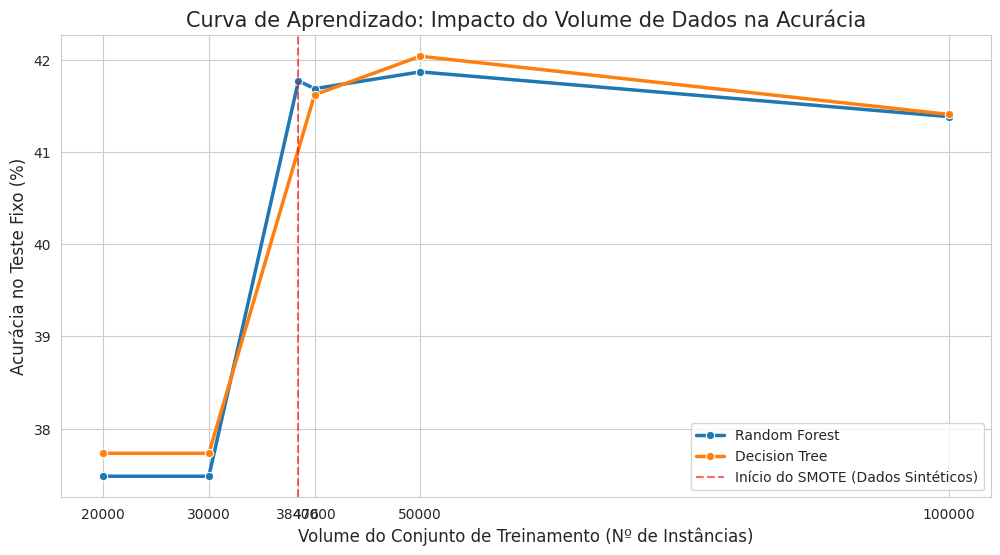


--- Ranking de Performance  ---
              Base         Modelo    Acc (%)  Volume
7        50k_SMOTE  Decision Tree  42.037599   50000
6        50k_SMOTE  Random Forest  41.867799   50000
10  38k (Original)  Random Forest  41.770770   38476
4        40k_SMOTE  Random Forest  41.685870   40000
5        40k_SMOTE  Decision Tree  41.619163   40000
9       100k_SMOTE  Decision Tree  41.406913  100000
8       100k_SMOTE  Random Forest  41.382656  100000
1     20k_resample  Decision Tree  37.731959   20000
3     30k_resample  Decision Tree  37.731959   30000
2     30k_resample  Random Forest  37.483323   30000
0     20k_resample  Random Forest  37.483323   20000


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Adicionar o resultado da Base Original que você já possui
# Nota: Como o treino original tem 38.476 instâncias, vamos usar esse valor para o eixo X
resultados_finais.append({
    'Base': '38k (Original)',
    'Modelo': 'Random Forest',
    'Acc (%)': 41.770770
})



# 2. Criar o DataFrame para o gráfico
df_grafico = pd.DataFrame(resultados_finais)

# 3. Mapear os nomes das bases para valores numéricos para o eixo X (ordenar corretamente)
mapeamento_volumes = {
    '20k_resample': 20000,
    '30k_resample': 30000,
    '38k (Original)': 38476,
    '40k_SMOTE': 40000,
    '50k_SMOTE': 50000,
    '100k_SMOTE': 100000
}
df_grafico['Volume'] = df_grafico['Base'].map(mapeamento_volumes)
df_grafico = df_grafico.sort_values('Volume')

# 4. Configurar o estilo do gráfico
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plotar as linhas para cada modelo
sns.lineplot(data=df_grafico, x='Volume', y='Acc (%)', hue='Modelo', marker='o', linewidth=2.5)

# Adicionar uma linha vertical destacando onde começa o SMOTE
plt.axvline(x=38476, color='red', linestyle='--', alpha=0.6, label='Início do SMOTE (Dados Sintéticos)')

# Customização de títulos e eixos
plt.title('Curva de Aprendizado: Impacto do Volume de Dados na Acurácia', fontsize=15)
plt.xlabel('Volume do Conjunto de Treinamento (Nº de Instâncias)', fontsize=12)
plt.ylabel('Acurácia no Teste Fixo (%)', fontsize=12)
plt.xticks([20000, 30000, 38476, 40000, 50000, 100000])
plt.legend()

plt.show()

# 5. Exibir a tabela final ordenada por performance
print("\n--- Ranking de Performance  ---")
print(df_grafico.sort_values(by='Acc (%)', ascending=False))